In [69]:
import argparse
import numpy as np
import pandas as pd
import torch
from tabulate import tabulate
from torch.utils.data import DataLoader
import os

from model import BertCustomBinaryClassifier
from utils.ensemble_utils import make_predictions
from utils.evaluate_metrics import evaluate_metrics
from utils.data_preprocessing import load_dataset

In [70]:
import logging
logging.getLogger("transforkmer_values.modeling_utils").setLevel(logging.ERROR)

In [71]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [72]:
parser = argparse.ArgumentParser()
parser.add_argument("--batch_size", type=int, default=64, help="")
parser.add_argument("--max_length", type=int, default=200, help="")
args = parser.parse_args(args=[])

# **BERT Models**

In [73]:
train_predictions_list, test_predictions_list = [], []  # Lists for storing model predictions
train_labels_list, test_labels_list = [], []  # Lists for storing true labels
train_logits_list, test_logits_list = [], [] # Lists to store logits

In [74]:
# Define directories
output_root_dir = "outputs"
npy_subfolder = "npy/classifier"
output_npy_dir = os.path.join(output_root_dir, npy_subfolder)

# Load the saved files
train_predictions_list = np.load(os.path.join(output_npy_dir, "train_predictions.npy"), allow_pickle=True)
test_predictions_list = np.load(os.path.join(output_npy_dir, "test_predictions.npy"), allow_pickle=True)
train_labels_list = np.load(os.path.join(output_npy_dir, "train_labels.npy"), allow_pickle=True)
test_labels_list = np.load(os.path.join(output_npy_dir, "test_labels.npy"), allow_pickle=True)
train_logits_list = np.load(os.path.join(output_npy_dir, "train_logits.npy"), allow_pickle=True)
test_logits_list = np.load(os.path.join(output_npy_dir, "test_logits.npy"), allow_pickle=True)

# Confirm the shapes of loaded data
print(f"Shape of train_predictions_list: {[len(item) for item in train_predictions_list]}")
print(f"Shape of test_predictions_list: {[len(item) for item in test_predictions_list]}")
print(f"Shape of train_labels_list: {[len(item) for item in train_labels_list]}")
print(f"Shape of test_labels_list: {[len(item) for item in test_labels_list]}")
print(f"Shape of train_logits_list: {[item.shape for item in train_logits_list]}")
print(f"Shape of test_logits_list: {[item.shape for item in test_logits_list]}")

Shape of train_predictions_list: [1484, 1484, 1484, 1484]
Shape of test_predictions_list: [200, 200, 200, 200]
Shape of train_labels_list: [1484, 1484, 1484, 1484]
Shape of test_labels_list: [200, 200, 200, 200]
Shape of train_logits_list: [(1484, 768), (1484, 768), (1484, 768), (1484, 768)]
Shape of test_logits_list: [(200, 768), (200, 768), (200, 768), (200, 768)]


# **Machine Learning Models**

In [75]:
from sklearn.ensemble import  ExtraTreesClassifier

In [76]:
# Prepare meta-features for training and testing
train_meta_features = np.column_stack(train_predictions_list)
test_meta_features = np.column_stack(test_predictions_list)

train_labels = train_labels_list[0]     
test_labels = test_labels_list[0]

In [77]:
model = ExtraTreesClassifier(n_estimators=1000, random_state=42)

threshold = 0.9999  

# Train the Stacking Classifier on the training set
model.fit(train_meta_features, train_labels)

# Meta-model predictions on the validation set
train_predictions_et = model.predict_proba(train_meta_features)[:, 1]
test_predictions_et = model.predict_proba(test_meta_features)[:, 1]

train_acc, train_sn, train_sp, train_mcc, train_auc = evaluate_metrics(train_predictions_et, train_labels, threshold=threshold)
test_acc, test_sn, test_sp, test_mcc, test_auc = evaluate_metrics(test_predictions_et, test_labels, threshold=threshold)

# Display results in table using tabulate
results = [["Train", train_acc, train_sn, train_sp, train_mcc, train_auc], ["Test", test_acc, test_sn, test_sp, test_mcc, test_auc]]

headers = ["Dataset", "Accuracy", "Sensitivity", "Specificity", "MCC", "AUC"]

print(tabulate(results, headers=headers, tablefmt="grid", floatfmt=".4f"))

+-----------+------------+---------------+---------------+--------+--------+
| Dataset   |   Accuracy |   Sensitivity |   Specificity |    MCC |    AUC |
+===========+============+===============+===============+========+========+
| Train     |     1.0000 |        1.0000 |        1.0000 | 1.0000 | 1.0000 |
+-----------+------------+---------------+---------------+--------+--------+
| Test      |     0.9900 |        1.0000 |        0.9800 | 0.9802 | 0.9900 |
+-----------+------------+---------------+---------------+--------+--------+


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import (
    precision_recall_curve,
    auc,
    average_precision_score,
    confusion_matrix,
    accuracy_score,
    recall_score,
    precision_score,
    f1_score,
    matthews_corrcoef
)


--- Plotting Confusion Matrix (Threshold = 0.9999) ---


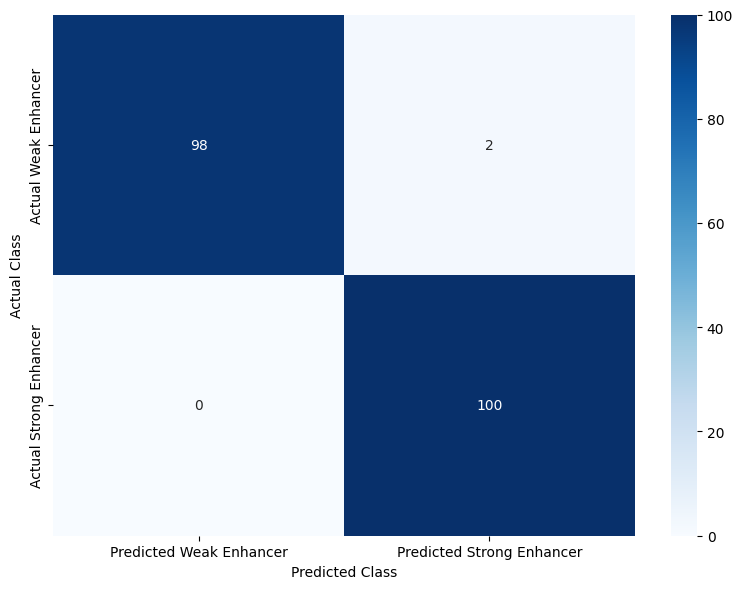

In [ ]:
# --- 3. Confusion Matrix ---

print(f"\n--- Plotting Confusion Matrix (Threshold = {threshold}) ---")
# Convert probabilities to binary predictions based on the threshold
test_predictions_binary = (test_predictions_et >= threshold).astype(int)

cm = confusion_matrix(test_labels, test_predictions_binary)
tn, fp, fn, tp = cm.ravel() # True Negatives (Weak), False Positives (Predicted Strong), False Negatives (Predicted Weak), True Positives (Strong)

# Plot
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Predicted Weak Enhancer', 'Predicted Strong Enhancer'],
            yticklabels=['Actual Weak Enhancer', 'Actual Strong Enhancer'])
plt.ylabel('Actual Class') 
plt.xlabel('Predicted Class') 
# plt.title(f'Confusion Matrix (Strong vs Weak Enhancer, Threshold = {threshold:.4f})')
plt.tight_layout()
# plt.savefig("analysis/extra/layer_2_confusion_matrix.pdf", format='pdf', bbox_inches='tight')
plt.show()

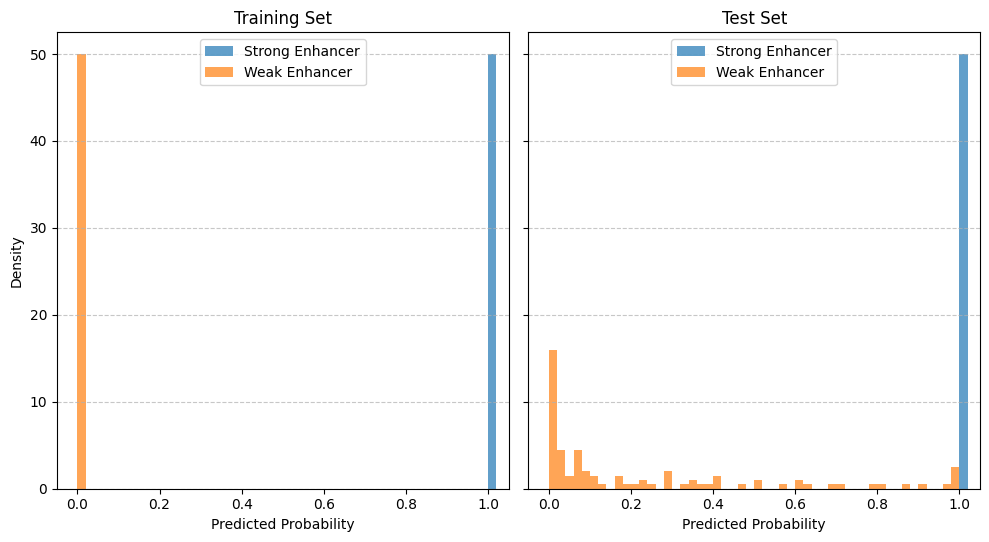

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Ensure labels are numpy arrays for boolean indexing
train_labels_np = np.array(train_labels)
test_labels_np = np.array(test_labels)

# Separate probabilities based on true labels
train_probs_label_0 = train_predictions_et[train_labels_np == 0]
train_probs_label_1 = train_predictions_et[train_labels_np == 1]

test_probs_label_0 = test_predictions_et[test_labels_np == 0]
test_probs_label_1 = test_predictions_et[test_labels_np == 1]

# --- Plotting ---
# Set up the figure with two subplots (one for train, one for test)
fig, axes = plt.subplots(1, 2, figsize=(10, 6), sharey=True)  # sharey makes y-axis consistent
# fig.suptitle('Distribution of Predicted Probabilities (Class 1)', fontsize=16)

# Define number of bins for histograms
num_bins = 50

# --- Plot 1: Training Set Distribution ---
# Plot histogram for True Label 1 on the same axes
axes[0].hist(train_probs_label_1, bins=num_bins, density=True, alpha=0.7, label="Strong Enhancer", color="tab:blue")
# Plot histogram for True Label 0
axes[0].hist(train_probs_label_0, bins=num_bins, density=True, alpha=0.7, label="Weak Enhancer", color="tab:orange")

axes[0].set_title("Training Set")
axes[0].set_xlabel("Predicted Probability")
axes[0].set_ylabel("Density")  # Use density=True for normalization
# axes[0].axvline(threshold, color='red', linestyle='--', label=f'Threshold ({threshold:.4f})')
axes[0].legend(loc="upper center")
axes[0].grid(axis="y", linestyle="--", alpha=0.7)
axes[0].set_xlim(-0.05, 1.05)  # <--- Add this line

# --- Plot 2: Test Set Distribution ---
# Plot histogram for True Label 1 on the same axes
axes[1].hist(test_probs_label_1, bins=num_bins, density=True, alpha=0.7, label="Strong Enhancer", color="tab:blue")
# Plot histogram for True Label 0
axes[1].hist(test_probs_label_0, bins=num_bins, density=True, alpha=0.7, label="Weak Enhancer", color="tab:orange")

axes[1].set_title("Test Set")
axes[1].set_xlabel("Predicted Probability")
# axes[1].set_ylabel('Density') # Y-label is shared, so commented out
# axes[1].axvline(threshold, color='red', linestyle='--', label=f'Threshold ({threshold:.4f})')
axes[1].legend(loc="upper center")
axes[1].grid(axis="y", linestyle="--", alpha=0.7)
axes[1].set_xlim(-0.05, 1.05)  # <--- Add this line

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
# plt.savefig("analysis/extra/layer_2_probability_distributions.pdf", format="pdf", bbox_inches="tight")
plt.show()


--- Plotting Feature Importance ---


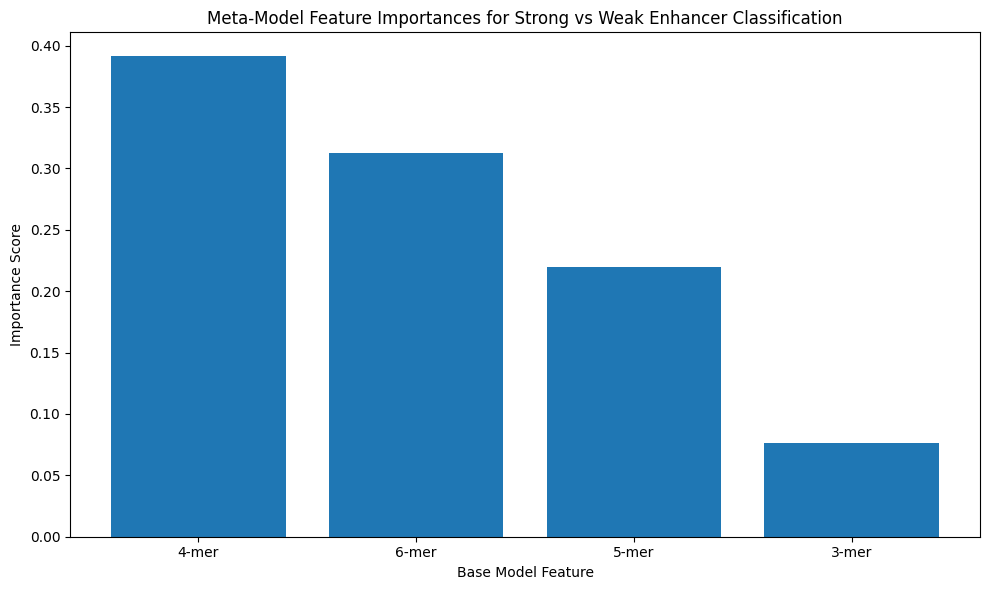

In [ ]:
# --- 5. Feature Importance Plot ---
print("\n--- Plotting Feature Importance ---")
importances = model.feature_importances_
n_features = train_meta_features.shape[1] # Get number of features
feature_names = [f'{i+3}-mer' for i in range(n_features)]

# Sort features by importance
indices = np.argsort(importances)[::-1]
sorted_importances = importances[indices]
sorted_feature_names = [feature_names[i] for i in indices]

plt.figure(figsize=(10, 6))
plt.bar(range(n_features), sorted_importances, align='center')
plt.xticks(range(n_features), sorted_feature_names)
plt.xlabel('Base Model Feature')
plt.ylabel('Importance Score')
plt.title('Meta-Model Feature Importances for Strong vs Weak Enhancer Classification')
plt.tight_layout() 
plt.show()


--- Plotting Performance Metrics vs. Threshold ---


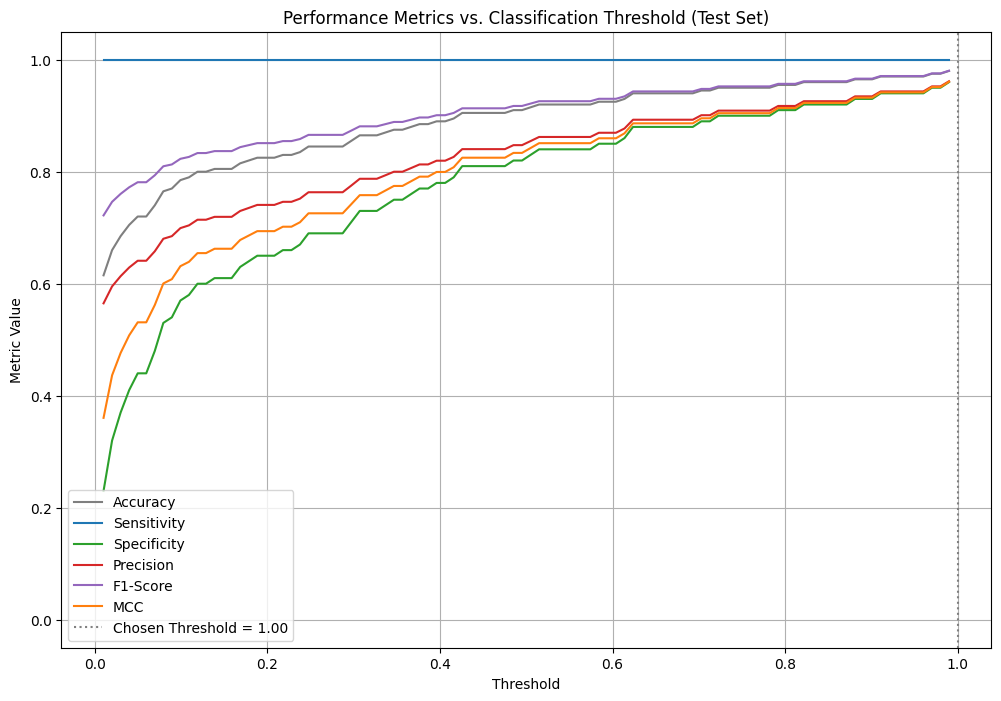


--- Plotting Complete ---


In [82]:
# --- 6. Performance Metrics vs. Threshold Plot ---
print("\n--- Plotting Performance Metrics vs. Threshold ---")
thresholds_range = np.linspace(0.01, 0.99, 100)# Range of thresholds to evaluate

# Lists to store metrics
accuracies = []
sensitivities = [] # Recall
specificities = []
precisions = []
f1_scores = []
mccs = []

for thr in thresholds_range:
    preds_binary = (test_predictions_et >= thr).astype(int)
    tn, fp, fn, tp = confusion_matrix(test_labels, preds_binary).ravel()

    accuracies.append(accuracy_score(test_labels, preds_binary))
    sensitivities.append(recall_score(test_labels, preds_binary, zero_division=0))
    specificities.append(tn / (tn + fp) if (tn + fp) > 0 else 0) # Manual Specificity
    precisions.append(precision_score(test_labels, preds_binary, zero_division=0))
    f1_scores.append(f1_score(test_labels, preds_binary, zero_division=0))
    mccs.append(matthews_corrcoef(test_labels, preds_binary))

# Plotting
plt.figure(figsize=(12, 8))
plt.plot(thresholds_range, accuracies, label='Accuracy', color='tab:gray')
plt.plot(thresholds_range, sensitivities, label='Sensitivity', color='tab:blue')
plt.plot(thresholds_range, specificities, label='Specificity', color='tab:green')
plt.plot(thresholds_range, precisions, label='Precision', color='tab:red')
plt.plot(thresholds_range, f1_scores, label='F1-Score', color='tab:purple')
plt.plot(thresholds_range, mccs, label='MCC', color='tab:orange')

# Mark the chosen threshold
plt.axvline(threshold, color='grey', linestyle=':', label=f'Chosen Threshold = {threshold:.2f}')

plt.title('Performance Metrics vs. Classification Threshold (Test Set)')
plt.xlabel('Threshold')
plt.ylabel('Metric Value')
plt.legend(loc='lower left') # Adjust legend location if needed
plt.grid(True)
plt.ylim([-0.05, 1.05]) # Set Y-axis limits
plt.show()

print("\n--- Plotting Complete ---")

In [83]:
print("\n--- Best Threshold Analysis for Each Metric ---")

# Function to find and print best threshold for a given metric
def print_best_threshold(metric_name, metric_values, thresholds):
    """Finds and prints the threshold yielding the max value for a metric."""
    if not metric_values: # Check if the list is empty
        print(f"{metric_name:<12}: No data available.")
        return

    try:
        best_idx = np.argmax(metric_values)
        best_thr = thresholds[best_idx]
        best_val = metric_values[best_idx]
        print(f"{metric_name:<12}: Max = {best_val:.4f} at Threshold = {best_thr:.4f}")
    except (ValueError, IndexError) as e:
        print(f"Could not calculate best threshold for {metric_name}: {e}")

# Calculate and print for each metric
print_best_threshold("Accuracy", accuracies, thresholds_range)
print_best_threshold("Sensitivity", sensitivities, thresholds_range)
print_best_threshold("Specificity", specificities, thresholds_range)
print_best_threshold("Precision", precisions, thresholds_range)
print_best_threshold("F1-Score", f1_scores, thresholds_range)
print_best_threshold("MCC", mccs, thresholds_range)

print("\n--- Analysis Complete ---")



--- Best Threshold Analysis for Each Metric ---
Accuracy    : Max = 0.9800 at Threshold = 0.9900
Sensitivity : Max = 1.0000 at Threshold = 0.0100
Specificity : Max = 0.9600 at Threshold = 0.9900
Precision   : Max = 0.9615 at Threshold = 0.9900
F1-Score    : Max = 0.9804 at Threshold = 0.9900
MCC         : Max = 0.9608 at Threshold = 0.9900

--- Analysis Complete ---


In [ ]:
print("\n--- Best Threshold Analysis using Equal Metric Weighting (Summation) ---")

# Check if lists are populated and have the correct length
if not all(isinstance(lst, list) and len(lst) == len(thresholds_range) for lst in [accuracies, sensitivities, specificities, precisions, f1_scores, mccs]):
    print("Error: Ensure all metric lists (accuracies, sensitivities, etc.) are populated and have the same length as thresholds_range.")
elif not thresholds_range.size > 0 :
     print("Error: thresholds_range is empty or not calculated.")
else:
    try:
        # Convert lists to NumPy arrays for efficient calculation
        accuracies_np = np.array(accuracies)
        sensitivities_np = np.array(sensitivities)
        specificities_np = np.array(specificities)
        precisions_np = np.array(precisions)
        f1_scores_np = np.array(f1_scores)
        mccs_np = np.array(mccs)

        combined_scores = (accuracies_np + sensitivities_np + specificities_np +
                           precisions_np + f1_scores_np + mccs_np)

        # Find the index where the combined score is maximized
        best_combined_idx = np.argmax(combined_scores)

        # Get the corresponding threshold and the maximum combined score
        best_combined_thr = thresholds_range[best_combined_idx]
        max_combined_score = combined_scores[best_combined_idx]

        print(f"Best Threshold (maximizing sum of all metrics): {best_combined_thr:.4f}")
        print(f"Maximum Combined Score value (Sum of Metrics): {max_combined_score:.4f}")

        # Display the individual metric values at this specific threshold
        print("\n--- Metrics at this 'Combined Best' Threshold ---")
        print(f"  Accuracy:    {accuracies[best_combined_idx]:.4f}")
        print(f"  Sensitivity: {sensitivities[best_combined_idx]:.4f}")
        print(f"  Specificity: {specificities[best_combined_idx]:.4f}")
        print(f"  Precision:   {precisions[best_combined_idx]:.4f}")
        print(f"  F1-Score:    {f1_scores[best_combined_idx]:.4f}")
        print(f"  MCC:         {mccs[best_combined_idx]:.4f}")

    except Exception as e:
        print(f"An error occurred during calculation: {e}")

print("\n--- Analysis Complete ---")


--- Best Threshold Analysis using Equal Metric Weighting (Summation) ---
Best Threshold (maximizing sum of all metrics): 0.9900
Maximum Combined Score value (Sum of Metrics): 5.8427

--- Metrics at this 'Combined Best' Threshold ---
  Accuracy:    0.9800
  Sensitivity: 1.0000
  Specificity: 0.9600
  Precision:   0.9615
  F1-Score:    0.9804
  MCC:         0.9608

--- Analysis Complete ---
